# Introduction to Simulation using SimPy

In [1]:
import simpy
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn
import random
import numpy as np

## Airport Security Process
(1) Individuals arrive at the boarding pass and ID check booths; (2) Individuals are assigned to the shortest scanner/metal detector line

*Notes on Simpy*
- the resources request() method generates an event that lets you wait until the resource becomes available again
- If you use the resource with the with statement as shown above, the resource is automatically being released. If you call request() without with, you are responsible to call release() once you are done using the resource.
- When you release a resource, the next waiting process is resumed and now “owns” one of the resource’s slots. The basic Resource sorts waiting processes in a FIFO (first in—first out) way.
- A resource needs a reference to an Environment and a capacity when it is created:


First, I'm going to create the Airport security system. Once I'm confident with the simulation mode, I'll loop through 100 simulations, and show a distribution of the average wait time.

In [2]:
#Airport Security
num_booths = 4
num_scanners = 4

arrival_rate = .2 
check_rate = 0.75 #minutes per passenger

min_time = 0.5 #min scan time - uniform dist
max_time = 1.0 #max scan time - uniform dist

run_time = 1440

avg_check_time = []
avg_scan_time = []
avg_wait_time = []


random.seed(24)

class Airport_Security(object):
    #airport security system
    def __init__(self,env,num_booths,num_scanners):
        self.env = env
        self.booth = simpy.Resource(env,capacity=num_booths)
        self.scanner = simpy.Resource(env,capacity=num_scanners)

    #1st process
    def boarding_pass_check(self,pass_arrival):
        #The boarding pass checking process
        booth_time = random.expovariate(1.0/check_rate)
        yield self.env.timeout(booth_time)
    #2nd process
    def scan_check(self,pass_arrival):
        #Scan/metal detector checking
        scan_rate = random.uniform(min_time,max_time)
        yield self.env.timeout(scan_rate)

    #Passengers arriving
def pass_arrival(env,pass_num,b):
    Arrivaltime = env.now
    with b.booth.request() as request:
        yield request
        yield env.process(b.boarding_pass_check(pass_num))
    
    first_stop = env.now - Arrivaltime
    avg_check_time.append(first_stop)
    
    with b.scanner.request() as request:
        yield request
        yield env.process(b.scan_check(pass_num))
    
    finish = env.now - first_stop
    avg_scan_time.append(finish - first_stop)
    
    passenger_time = env.now - Arrivaltime
    avg_wait_time.append(passenger_time)

def setup(env, num_booths, num_scanners):
    check = Airport_Security(env, num_booths, num_scanners,)
    # Create 4 initial people
    for i in range(4):
        env.process(pass_arrival(env,i,check))

    # Create more cars while the simulation is running
    while True:
        yield env.timeout(np.random.poisson(arrival_rate))
        i += 1
        env.process(pass_arrival(env,i,check))

# Simulation and setup process
random.seed(24)
env = simpy.Environment()
env.process(setup(env, num_booths, num_scanners))

#Execute
env.run(until = run_time)
print("Total Passengers:",len(avg_wait_time))
print("Avg total wait time:",sum(avg_wait_time)/len(avg_wait_time))


Total Passengers: 7505
Avg total wait time: 25.68827744534722


The code above only has one version of the simulation - to get a better idea of the true results, I'll do the simulation 100 times. I'll then speed up the passenger arrival time to model a busier airport, like Atlanta.

## Running the Simulation 100+ times
Now that I have my simulation up and running, I'm going to loop through it 100 times, and plot a histogram of the average wait time to get a general distribution of how long passengers are generally waiting. I'll first do this for num_booths = 4 and num_scanners = 4; however, if the wait times are too long, I'll have to adjust those numbers.

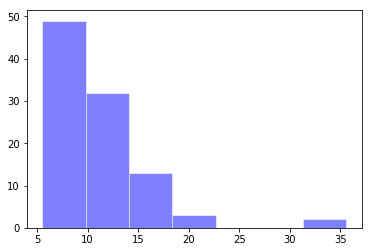

In [3]:
#Airport Security
num_booths = 4
num_scanners = 4

arrival_rate = .2 #5 per minute
check_rate = 0.75 

min_time = 0.5
max_time = 1.0 
reps = 100

Average_Time = []

for sim in range(1,reps):
    # Simulation and setup process
    random.seed(24)
    avg_check_time = []
    avg_scan_time = []
    avg_wait_time = []
    env = simpy.Environment()
    env.process(setup(env, num_booths, num_scanners))

    #Execute
    env.run(until = 1500)
    Average_Time.append(sum(avg_wait_time)/len(avg_wait_time))

num_bins = 7
n,bins,patches = plt.hist(Average_Time,num_bins,facecolor = 'blue', alpha = .5, edgecolor = 'white')
plt.show()

In [4]:
print("The overall average of the averages is:",round(sum(Average_Time)/len(Average_Time),2),"minutes")

The overall average of the averages is: 11.13 minutes


The histogram of the results is right skewed. This makes sense in our case. The wait times generally fall between 5-15 minutes, but still reach up to the 25 and 30 minute range occassionally. The overall average of the averages is just over 11 minutes. This probably seems a little unrealistic to those who live in big cities or travel a lot. For that reason, I'm going to do the same exact analysis, but increase the arrival rate to about 10 passenegers per minute. To compensate for this change a little bit, I'll add four more booths and three more scanners as well.

## Busy Airport Simulation

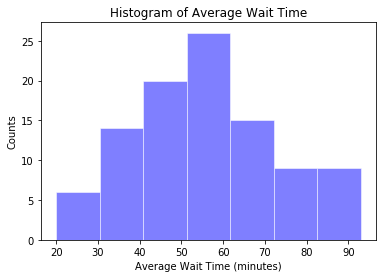

In [5]:
#Airport Security
num_booths = 8
num_scanners = 7

arrival_rate = .10 #About 10 per minute
check_rate = 0.75 

min_time = 0.5
max_time = 1.0 
reps = 100

Average_Time = []

for sim in range(1,reps):
    # Simulation and setup process
    random.seed(24)
    avg_check_time = []
    avg_scan_time = []
    avg_wait_time = []
    env = simpy.Environment()
    env.process(setup(env, num_booths, num_scanners))

    #Execute
    env.run(until = 1500)
    Average_Time.append(sum(avg_wait_time)/len(avg_wait_time))

num_bins = 7
n,bins,patches = plt.hist(Average_Time,num_bins,facecolor = 'blue', alpha = .5, edgecolor = 'white')
plt.xlabel('Average Wait Time (minutes)')
plt.ylabel('Counts')
plt.title('Histogram of Average Wait Time')
plt.show()

Just like that, the average wait increases *substantially*. The average wait times now reach up to 90+ minutes, with a mean/median of around 55 minutes. For some airports, this is probabaly very realistic. Luckily for me, I primarily fly out of Milwaukee, WI and Madison, WI, so I rarely see wait times of this scale.